# Pre-processing Molecules

You’ve probably heard the adage “garbage in, garbage out” before in reference to the importance of data quality when it comes to AI/ML. The same holds true in the field of drug discovery. Given the scarcity and often non-consistent quality of available data for drug discovery, an initial clean up is almost always required to ensure the use of high quality data in the generation of your models. If you don’t do this, the use of lesser quality data would definitely impact the accuracy of your models in any downstream task. Pre-processing of data and molecules is extremely important, let’s dive in!

## Representing Molecules

There are many ways in which molecules can be represented. In other words, how can we effectively express the complexity of a molecule in a way that machines can understand? Here are some existing methods: 

- [Molfile](https://en.wikipedia.org/wiki/Chemical_table_file) - A table that holds information about the atoms, bonds, connectivity and coordinates of a molecule
- **SMILES** - stands for **S**implified **M**olecular **I**nput **L**ine-**E**ntry **S**ystem and the name essentially describes it. It’s a line notation for encoding molecular structures where atoms are represented by their standard abbreviation as a chemical element (i.e. C for carbon, N for nitrogen etc.). Multiple symbols are then used to define elements with charges, bonds, rings, aromaticity, stereochemistry, and much more. For more detail, read [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Terminology).
    - As an example, CCO, OCC and C(O)C all refer to ethanol. Having a number of equally valid SMILES strings for a given molecule can be an issue, therefore, canonicalization algorithms can be used to generate canonical SMILES to produce unique and consistent SMILES strings.
    - Although SMILES are commonly used, they are not perfect. In a generative model using SMILES as inputs and outputs, there are often invalid SMILES strings that are produced (i.e. the SMILE string corresponds to an invalid molecule that violates basic chemical rules).
- **SELFIES** - stands for **SELF**-referenc**I**ng **E**mbedded **S**trings, it is another string-based representation for molecules that is generally more suitable for ML models and exhibits more robustness (i.e. more SELFIE strings corresponds to a valid molecule). Read more [here](https://aspuru.substack.com/p/molecular-graph-representations-and).
- **InChi** - another string-based method of representing chemical structures developed by IUPAC. Read more [here](https://iupac.org/100/stories/what-on-earth-is-inchi/). On the other hand, [InChi key](https://dev.drugbank.com/guides/terms/inchi-key) is a newer version of InChi that is only useful to identify molecules, however, it is impossible to reconstruct a molecule from an InChi key.

See below for a graphic that summarizes some of the methods discussed in the section above: 

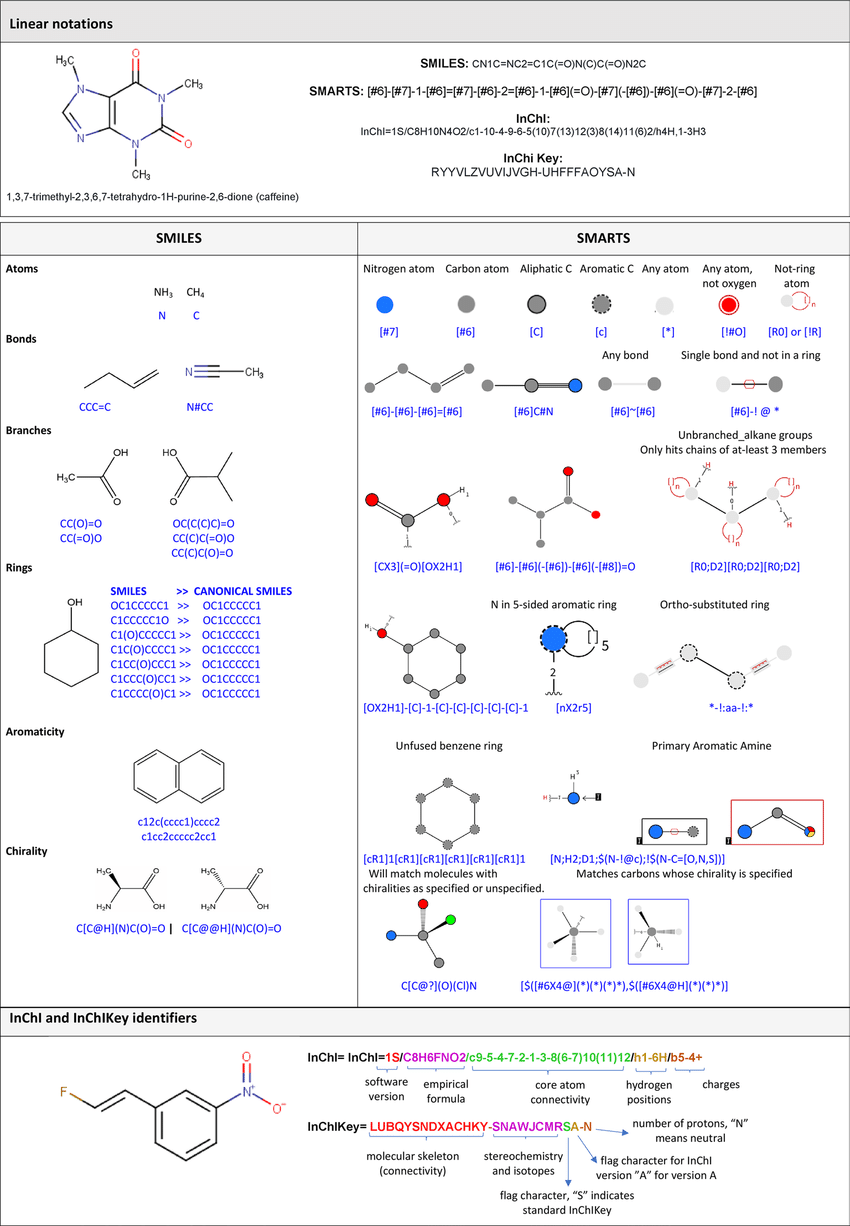

***[Source](https://www.researchgate.net/publication/344906202_Chemoinformatics-based_enumeration_of_chemical_libraries_a_tutorial)***

**Note:** it’s important to understand that all forms of molecular representation have their pro’s and con’s. It’s less of a “one-size-fits-all” and more about picking and choosing specific methods to represent a molecule given your specific use case. 

## Sanitize and Standardize

***Molecular sanitization*** is the process of ensuring that the molecules in your dataset ***are realistic***. You can read more about the sanitization procedure as applied in the RDKit [here](https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization). In Datamol, there are a few extra steps as well, sanitization is done under the following procedure: 

1. Adjusting for nitrogen aromaticity since faulty valence for nitrogen in aromatic rings is  [currently](https://github.com/rdkit/rdkit/issues/2011) an issue in RDKit through the Sanifix algorithm. 
2. An extra conversion is done from mol → smiles → mol to ensure that the molecules are valid SMILES.
3. Charge neutralization - this is NOT charge removal, it attempts to correct valence issues arising from incorrect charges being placed on atoms.

Users can control the application of the sanifix algorithim or charge neutralization, users can toggle the respective parameters ***sanifix*** and ***charge_neutral*** to be TRUE/FALSE. 

The process of **standardization** is used to generate ***canonical SMILES.*** It is currently done using the following procedure which can be controlled by the user through the described parameters below:

- ***disconnect_metals -*** metal disconnection
    - Depending on the source of the database, some compounds may be reported in salt form or associated to metallic ions (e.g. the sodium salt of a carboxylic compound). In most cases, these counter-ions are not relevant so the use of this function is required before further utilization of the dataset.)
    - More details [here](https://molvs.readthedocs.io/en/latest/guide/standardize.html#disconnect-metals)
- ***normalize -*** ion (charge) and functional groups normalization
    - It corrects drawing errors and standardizes functional groups in the molecule as well as ensuring the overall proper charge of the compound
    - More details [here](https://molvs.readthedocs.io/en/latest/guide/standardize.html#apply-normalization-rules)
- ***reionize -*** reionization of the molecule (protonation following the acidity order)
    - If one or more acidic functionalities are present in the molecule, this option ensures the correct neutral/ionized state for such functional groups. Molecules are uncharged by adding and/or removing hydrogens. For zwitterions, hydrogens are moved to eliminate charges where possible. However, in cases where there is a positive charge that is not neutralizable, an attempt is made to also preserve the corresponding negative charge
    - Read more [here](https://molvs.readthedocs.io/en/latest/guide/standardize.html#reionize-acids)
- ***uncharge* -** charge removal
    - This option neutralize the molecule by reversing the protonation state of protonated and deprotonated groups, if present (e.g. a carboxylate is re-protonated to the corresponding carboxylic acid).
    - In cases where there is a positive charge that is not neutralizable, an attempt is made to also preserve the corresponding negative charge to ensure a net zero charge.
- ***stereo -*** stereochemistry proper reassignment if missing.
    - Stereochemical information is corrected and/or added if missing using built-in RDKit functionality to force a clean recalculation of stereochemistry

The actual processes for sanitization and standardization described can get a bit too detailed, with lots of chemistry terminology. We recommend just sticking with the defaults already set in Datamol. It’s enough just to understand the importance of why we sanitize and standardize our datasets as a key step in the pre-processing, as you continue spending time in the AI/ML for drug discovery field, you will get more familiar with the details. 

## Tutorial

In this tutorial, let’s walk through how to load a dataset and then apply the described pre-processing pipeline which will take a list of molecules and: 

- Convert to a mol.
- Fix common errors in the mol.
- Sanitize the mol.
- Standardize the mol.
- Generate a standardized SMILES.
- Generate SELFIES.
- Generate InChi and InChi key.
- Save the results as CSV or SDF file formats.

From here, we will generate a table where it can more easily visualized. The option of parallelization will also be shown: 

**Note:** parallelizing the preprocessing will only be faster if your dataset is very large. 

In [1]:
import pandas as pd
import datamol as dm

dm.disable_rdkit_log()

In [2]:
# Load a dataset
data = dm.data.freesolv()
print(data.shape)
data.head()

(642, 4)


,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


In [6]:
smiles_column = "smiles"

def _preprocess(row):
    mol = dm.to_mol(row[smiles_column], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True)

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

data_clean = data.apply(_preprocess, axis=1)    
data_clean.head()

,iupac,smiles,expt,calc,standard_smiles,selfies,inchi,inchikey
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,COc1ccc(C(=O)N(C)C)cc1,[C][O][C][=C][C][=C][Branch1][#Branch2][C][=Br...,InChI=1S/C10H13NO2/c1-11(2)10(12)8-4-6-9(13-3)...,OCGXPFSUJVHRHA-UHFFFAOYSA-N
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,CS(=O)(=O)Cl,[C][S][=Branch1][C][=O][=Branch1][C][=O][Cl],"InChI=1S/CH3ClO2S/c1-5(2,3)4/h1H3",QARBMVPHQWIHKH-UHFFFAOYSA-N
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,C=CC(C)C,[C][=C][C][Branch1][C][C][C],"InChI=1S/C5H10/c1-4-5(2)3/h4-5H,1H2,2-3H3",YHQXBTXEYZIYOV-UHFFFAOYSA-N
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,CCc1cnccn1,[C][C][C][=C][N][=C][C][=N][Ring1][=Branch1],"InChI=1S/C6H8N2/c1-2-6-5-7-3-4-8-6/h3-5H,2H2,1H3",KVFIJIWMDBAGDP-UHFFFAOYSA-N
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,CCCCCCCO,[C][C][C][C][C][C][C][O],"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3",BBMCTIGTTCKYKF-UHFFFAOYSA-N


In [7]:
smiles_column = "smiles"

def _preprocess(i, row):

    dm.disable_rdkit_log()

    mol = dm.to_mol(row[smiles_column], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True)

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

data_clean = dm.parallelized(_preprocess, data.iterrows(), arg_type='args', progress=True, total=len(data))
data_clean = pd.DataFrame(data_clean)
data_clean.head()

  0%|          | 0/642 [00:00<?, ?it/s]

,iupac,smiles,expt,calc,standard_smiles,selfies,inchi,inchikey
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,COc1ccc(C(=O)N(C)C)cc1,[C][O][C][=C][C][=C][Branch1][#Branch2][C][=Br...,InChI=1S/C10H13NO2/c1-11(2)10(12)8-4-6-9(13-3)...,OCGXPFSUJVHRHA-UHFFFAOYSA-N
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,CS(=O)(=O)Cl,[C][S][=Branch1][C][=O][=Branch1][C][=O][Cl],"InChI=1S/CH3ClO2S/c1-5(2,3)4/h1H3",QARBMVPHQWIHKH-UHFFFAOYSA-N
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,C=CC(C)C,[C][=C][C][Branch1][C][C][C],"InChI=1S/C5H10/c1-4-5(2)3/h4-5H,1H2,2-3H3",YHQXBTXEYZIYOV-UHFFFAOYSA-N
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,CCc1cnccn1,[C][C][C][=C][N][=C][C][=N][Ring1][=Branch1],"InChI=1S/C6H8N2/c1-2-6-5-7-3-4-8-6/h3-5H,2H2,1H3",KVFIJIWMDBAGDP-UHFFFAOYSA-N
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,CCCCCCCO,[C][C][C][C][C][C][C][O],"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3",BBMCTIGTTCKYKF-UHFFFAOYSA-N


## References

- [https://depth-first.com/articles/2020/07/27/a-guide-to-molecular-standardization/](https://depth-first.com/articles/2020/07/27/a-guide-to-molecular-standardization/)
- Wikipedia - [https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Terminology](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Terminology)